In [ ]:
!curl -o dataset.zip https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/ccr8cm22vz-1.zip
!unzip dataset.zip
!unrar x "/content/Anemia Detection using Palpable Palm Image Datasets from Ghana/Palm.rar" > op

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  231M  100  231M    0     0  13.9M      0  0:00:16  0:00:16 --:--:-- 16.1M
Archive:  dataset.zip
  inflating: Anemia Detection using Palpable Palm Image Datasets from Ghana/Palm.rar  


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

anemic = []
non_anemic = []
for filename in os.listdir('/content/Palm/'):
  if 'Non' in filename:
    non_anemic.append(filename)
  else:
    anemic.append(filename)


In [ ]:
def read_img(filepath):
  img = cv2.imread(filepath)
  img = cv2.resize(img, (227, 227))
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  # l, a, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
  # return b
  return img

In [ ]:
dataset = []
labels = []
path = '/content/Palm/'
for filename in tqdm(anemic):
  labels.append(0)
  img = read_img(os.path.join(path, filename))
  dataset.append(img)
for filename in tqdm(non_anemic):
  labels.append(1)
  img = read_img(os.path.join(path, filename))
  dataset.append(img)
dataset = np.array(dataset)
labels = np.array(labels)

100%|██████████| 1698/1698 [00:03<00:00, 464.46it/s]


In [ ]:
from tensorflow import keras

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

train_x, test_x, train_y, test_y = train_test_split(dataset, labels, test_size=0.2, random_state=2)
train_x = tf.data.Dataset.from_tensor_slices(train_x)
test_x = tf.data.Dataset.from_tensor_slices(test_x)
train_y = tf.data.Dataset.from_tensor_slices(train_y)
test_y = tf.data.Dataset.from_tensor_slices(test_y)

train_ds = tf.data.Dataset.zip((train_x, train_y))
test_ds = tf.data.Dataset.zip((test_x, test_y))


In [ ]:
def build_alexnet(in_shape, classes):
  inputs = keras.Input(shape=(in_shape))
  inputs = keras.layers.Rescaling(scale=1/255)(inputs)

  c1 = keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), input_shape=in_shape)(inputs)
  c1 = keras.layers.PReLU()(c1)
  c1 = keras.layers.BatchNormalization()(c1)
  c1 = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(c1)

  c2 = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same")(c1)
  c2 = keras.layers.PReLU()(c2)
  c2 = keras.layers.BatchNormalization()(c2)
  c2 = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(c2)

  c3 = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same")(c2)
  c3 = keras.layers.PReLU()(c3)
  c3 = keras.layers.BatchNormalization()(c3)

  c4 = keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), padding="same")(c3)
  c4 = keras.layers.PReLU()(c4)
  c4 = keras.layers.BatchNormalization()(c4)

  c5 = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding="same")(c4)
  c5 = keras.layers.PReLU()(c5)
  c5 = keras.layers.BatchNormalization()(c5)
  c5 = keras.layers.MaxPool2D(pool_size=(2,2))(c5)

  attn = keras.layers.GlobalAveragePooling2D()(c5)
  attn = keras.layers.Flatten()(attn)
  attn = keras.layers.Dense(512, kernel_regularizer='l1_l2', activation='sigmoid')(attn)
  attn = keras.layers.Dense(256, kernel_regularizer='l1_l2', activation='sigmoid')(attn)
  c5 = keras.layers.Multiply()([c5, attn]) # across channel attention

  f1 = keras.layers.Flatten()(c5)
  # f2 = keras.layers.Multiply()([c1_branch, f1])
  # f = keras.layers.Add()([f1, f2])
  l1 = keras.layers.Dense(1024,activation='relu')(f1)
  l1 = keras.layers.Dropout(0.5)(l1)
  l2 = keras.layers.Dense(1024,activation='relu')(l1)
  l2 = keras.layers.Dropout(0.5)(l2)
  l3 = keras.layers.Dense(classes,activation='softmax')(l2)

  model = keras.Model(inputs=[inputs], outputs=[l3])
  return model

In [ ]:
alexnet = build_alexnet((227, 227, 3), classes=2)
alexnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 55, 55, 96)   34944       ['input_2[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 55, 55, 96)   290400      ['conv2d[1][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 55, 55, 96)  384         ['p_re_lu[1][0]']            

In [ ]:
 alexnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model_callbacks = [keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=40,
)]
batch_size = 16
log = alexnet.fit(train_ds.batch(batch_size), epochs=100, verbose=2, validation_data=test_ds.batch(batch_size),
                  callbacks=model_callbacks)

Epoch 1/100
213/213 - 24s - loss: 20.3489 - accuracy: 0.5493 - val_loss: 1.0001 - val_accuracy: 0.5892 - 24s/epoch - 113ms/step
Epoch 2/100
213/213 - 6s - loss: 0.9902 - accuracy: 0.6030 - val_loss: 0.9973 - val_accuracy: 0.4965 - 6s/epoch - 27ms/step
Epoch 3/100
213/213 - 6s - loss: 0.9600 - accuracy: 0.6147 - val_loss: 0.9456 - val_accuracy: 0.6080 - 6s/epoch - 27ms/step
Epoch 4/100
213/213 - 6s - loss: 0.9424 - accuracy: 0.6262 - val_loss: 1.0929 - val_accuracy: 0.5822 - 6s/epoch - 28ms/step
Epoch 5/100
213/213 - 6s - loss: 0.9269 - accuracy: 0.6482 - val_loss: 1.1366 - val_accuracy: 0.5493 - 6s/epoch - 28ms/step
Epoch 6/100
213/213 - 6s - loss: 0.9200 - accuracy: 0.6552 - val_loss: 1.0083 - val_accuracy: 0.5258 - 6s/epoch - 28ms/step
Epoch 7/100
213/213 - 6s - loss: 0.9111 - accuracy: 0.6620 - val_loss: 0.9776 - val_accuracy: 0.6397 - 6s/epoch - 28ms/step
Epoch 8/100
213/213 - 6s - loss: 0.8930 - accuracy: 0.6731 - val_loss: 1.0361 - val_accuracy: 0.6420 - 6s/epoch - 27ms/step
Epoc

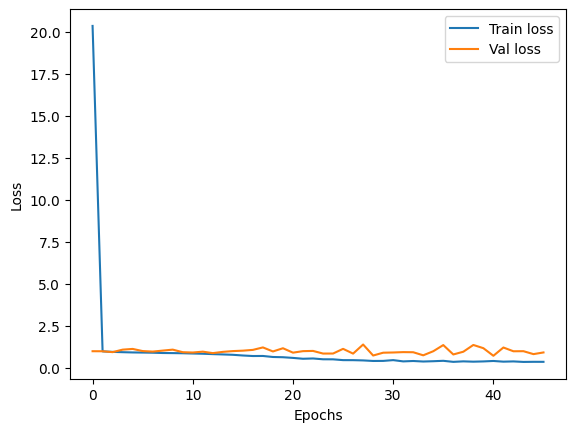

Model performance on test dataset: 
Loss: 0.7284280061721802
Accuracy: 0.9037558436393738
54/54 [==============================] - 1s 10ms/step
[[493  37]
 [ 45 277]]
Model performance on train dataset: 
Loss: 0.36699819564819336
Accuracy: 0.9873826503753662
213/213 [==============================] - 2s 10ms/step
[[2020   12]
 [  31 1345]]


In [ ]:
from matplotlib import pyplot as plt
plt.plot(log.history['loss'])
plt.plot(log.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train loss", "Val loss"])
plt.show()

loss, acc = alexnet.evaluate(test_ds.batch(batch_size), verbose=0)
print("Model performance on test dataset: ")
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

y_pred = alexnet.predict(test_x.batch(batch_size))
y_pred = tf.math.argmax(
    y_pred,
    axis=1)
y_test_list = list(test_y.as_numpy_iterator())
cm = tf.math.confusion_matrix(y_test_list, y_pred).numpy()
print(cm)

loss, acc = alexnet.evaluate(train_ds.batch(batch_size), verbose=0)
print("Model performance on train dataset: ")
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

y_pred = alexnet.predict(train_x.batch(batch_size))
y_pred = tf.math.argmax(
    y_pred,
    axis=1)
y_train_list = list(train_y.as_numpy_iterator())
cm = tf.math.confusion_matrix(y_train_list, y_pred).numpy()
print(cm)

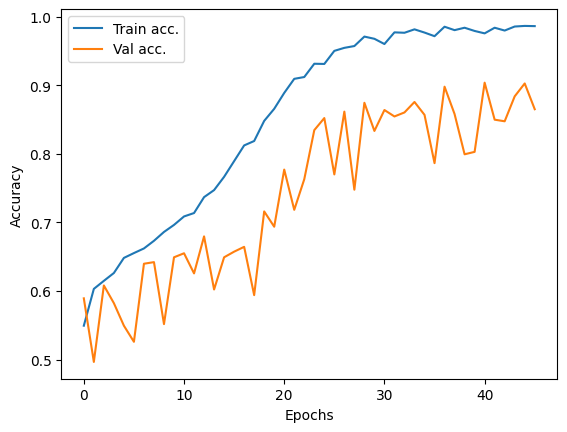

In [ ]:
plt.plot(log.history['accuracy'])
plt.plot(log.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train acc.", "Val acc."])
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
alexnet.save('./drive/MyDrive/ch-attn-alexnet.h5')